# Convolutional Neural Network - MNIST Fashion


### Loading and Normalizing Data

In [284]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [285]:
train_dataset = torchvision.datasets.FashionMNIST(
    root='.',
    train=True,
    transform=transforms.ToTensor(),
    download=True)

In [286]:
#train_normalized = train_dataset.data.numpy()/255.

#train_dataset.data = torch.Tensor(train_normalized)

In [287]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [288]:
train_dataset.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [289]:
test_dataset = torchvision.datasets.FashionMNIST(
    root='.',
    train=False,
    transform=transforms.ToTensor(),
    download=True)

In [290]:
#test_normalized = test_dataset.data.numpy()/255.

#test_dataset.data = torch.Tensor(test_normalized)

In [291]:
# number of classes
K = len(set(train_dataset.targets.numpy()))
print("number of classes:", K)

number of classes: 10


### Building the Convolutional Neural Network Class

In [292]:
class CNN_Rafael(nn.Module):

    def __init__(self, K):

        super(CNN_Rafael, self).__init__()

        self.conv_layers = nn.Sequential(

            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
            nn.ELU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
            nn.ELU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
            nn.ELU()
        )

        self.dense_layers = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(128 * 2 * 2, 512),
            nn.ELU(),
            nn.Dropout(0.2),
            nn.Linear(512, K)
        )

        
    def forward(self, X):
        out = self.conv_layers(X)
        out = out.view(out.size(0), -1)
        out = self.dense_layers(out)
        return out



In [293]:
model = CNN_Rafael(K)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [294]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
  train_losses = np.zeros(epochs)
  
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    
    model.train()

    train_loss = []
    
    for inputs, targets in train_loader:
    
      optimizer.zero_grad()
    
      outputs = model(inputs)
    
      loss = criterion(outputs, targets)
        
      loss.backward()
    
      optimizer.step()

      train_loss.append(loss.item())

    train_loss = np.mean(train_loss) 
    
    model.eval()
    
    test_loss = []

    for inputs, targets in test_loader:
      
      outputs = model(inputs)
      
      loss = criterion(outputs, targets)
      
      test_loss.append(loss.item())
    
    test_loss = np.mean(test_loss)


    train_losses[it] = train_loss
    
    test_losses[it] = test_loss


    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
      Test Loss: {test_loss:.4f}')
  
  return train_losses, test_losses

In [295]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

### Training the Network

In [296]:
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs=15)

Epoch 1/15, Train Loss: 0.6036,       Test Loss: 0.4695
Epoch 2/15, Train Loss: 0.4455,       Test Loss: 0.4458
Epoch 3/15, Train Loss: 0.4003,       Test Loss: 0.4127
Epoch 4/15, Train Loss: 0.3696,       Test Loss: 0.3803
Epoch 5/15, Train Loss: 0.3475,       Test Loss: 0.3733
Epoch 6/15, Train Loss: 0.3277,       Test Loss: 0.3551
Epoch 7/15, Train Loss: 0.3118,       Test Loss: 0.3403
Epoch 8/15, Train Loss: 0.2984,       Test Loss: 0.3419
Epoch 9/15, Train Loss: 0.2828,       Test Loss: 0.3341
Epoch 10/15, Train Loss: 0.2663,       Test Loss: 0.3380
Epoch 11/15, Train Loss: 0.2517,       Test Loss: 0.3579
Epoch 12/15, Train Loss: 0.2390,       Test Loss: 0.3370
Epoch 13/15, Train Loss: 0.2289,       Test Loss: 0.3496
Epoch 14/15, Train Loss: 0.2181,       Test Loss: 0.3481
Epoch 15/15, Train Loss: 0.2128,       Test Loss: 0.3509


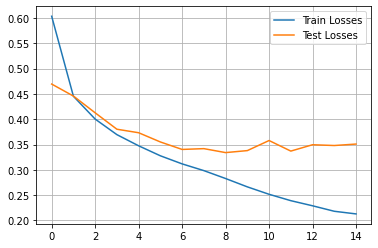

In [298]:
plt.plot(train_losses, label='Train Losses')
plt.plot(test_losses, label='Test Losses')
plt.legend()
plt.grid()

In [299]:
model.eval()
n_correct = 0.
n_total = 0.

for inputs, targets in train_loader:

  outputs = model(inputs)

  _, predictions = torch.max(outputs, 1)
  
  n_correct += (predictions == targets).sum().item()

  n_total += targets.shape[0]

train_acc = n_correct / n_total


n_correct = 0.
n_total = 0.

for inputs, targets in test_loader:

  outputs = model(inputs)

  _, predictions = torch.max(outputs, 1)
  

  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9448, Test acc: 0.8912


In [304]:
x_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()
p_test = np.array([])

for inputs, targets in test_loader:

  outputs = model(inputs)

  _, predictions = torch.max(outputs, 1)
  
  p_test = np.concatenate((p_test, predictions.cpu().numpy()))


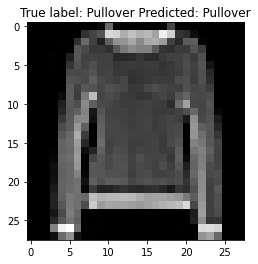

In [321]:
labels = '''T-shirt/top
Trouser
Pullover
Dress
Coat
Sandal
Shirt
Sneaker
Bag
Ankle boot'''.split("\n")

p_test = p_test.astype(np.uint8)
classified_idx = np.where(p_test == y_test)[0]
i = np.random.choice(classified_idx)
plt.imshow(x_test[i].reshape(28,28), cmap='gray')
plt.title("True label: %s Predicted: %s" % (labels[y_test[i]], labels[p_test[i]]));

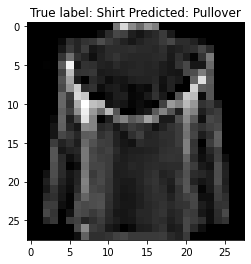

In [325]:
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i].reshape(28,28), cmap='gray')
plt.title("True label: %s Predicted: %s" % (labels[y_test[i]], labels[p_test[i]]));